(100, 100)


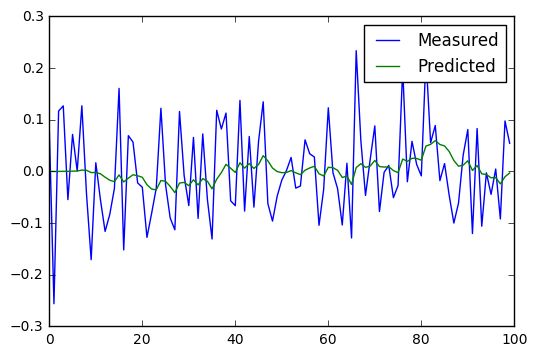

In [28]:
import cv2, numpy as np
import time, random
import matplotlib 
import matplotlib.pyplot as plt

meas=[]
pred=[]
mp = np.array((1,1),np.float32) # measurement
tp = np.zeros((1,1),np.float32) # tracked / prediction

kalman = cv2.KalmanFilter(2,1) # 2D state (distance and velocity), 1D measurement (distance)
kalman.measurementMatrix = np.array([[1,1]], np.float32)
kalman.transitionMatrix = np.array([[1,1], [0,1]], np.float32)
kalman.processNoiseCov = np.array([[1,0], [0,1]], np.float32) * 0.00003
kalman.measurementNoiseCov = np.array([[1]], np.float32) * 0.3

steps = 100
for i in range(steps):
        mp = np.array([[np.random.normal(0, 0.1)]], np.float32)
        meas.append(mp[0])
        kalman.correct(mp)
        tp = kalman.predict()
        pred.append(tp[0])
        #print("Measured: %s, estimated: %s" % (mp[0], tp[0]))
        #time.sleep(0.1)

time = np.arange(0, steps)
print(len(time), len(meas))
meas_lab, = plt.plot(time, meas, label = "Measured")
est_lab, = plt.plot(time, pred, label = "Predicted")

plt.legend(handles=[meas_lab, est_lab])
plt.show()